## Fields

In [1]:
# import packages
import sys
import os
from dotenv import load_dotenv
from IPython.display import display, HTML
import json
import matplotlib.pyplot as plt
import folium
import pandas as pd
import geopandas as gpd

# Load environment variables from .env file
load_dotenv()

# import the API builder
sys.path.append(os.path.abspath("../../"))
from scoutmaster.api import ScoutMasterAPI

In [2]:
# Scoutmaster API - Credentials
client_id = os.getenv('SM_CLIENT_ID')
client_secret = os.getenv('SM_CLIENT_SECRET')
project_id = os.getenv('SM_PROJECT_ID')
dev = os.getenv("DEV")

# Scoutmaster API - Init
SM_API = ScoutMasterAPI(dev)
SM_API.authenticate(client_id=client_id, client_secret=client_secret)

✅ Successfully authenticated ScoutMaster API
HOST: https://dev-api.scoutmaster.nl/v2/


In [3]:
output_folder = "../../data/output/"

In [4]:
SM_API.output_format = 'df'
df_observations = SM_API.observations(project_id=project_id)
 

In [5]:
SM_API.output_format = 'geojson'
geojson_fields = SM_API.fields(project_id)

output_file =  output_folder + 'fields.geojson'
with open(output_file, "w") as f:
    if isinstance(geojson_fields, str):
        f.write(geojson_fields)
    else:
        # If it's a Python dict, convert to JSON first
        json.dump(geojson_fields, f, indent=2)

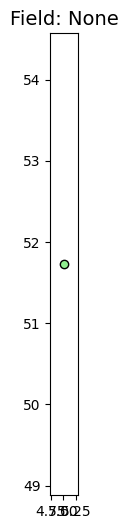

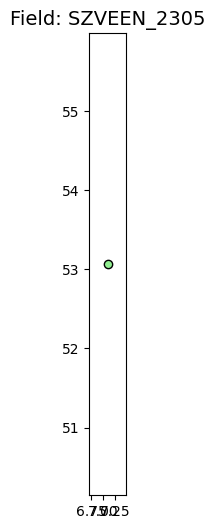

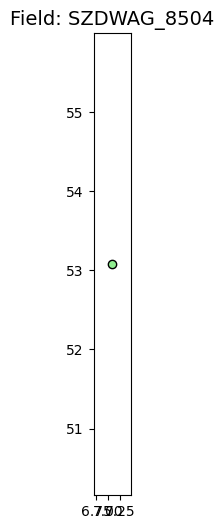

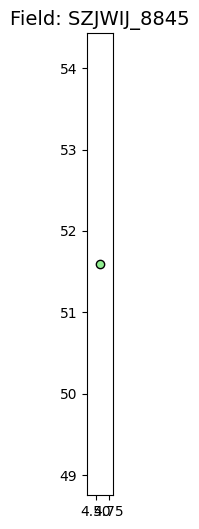

In [9]:
SM_API.output_format = 'gdf'
gdf_obs = SM_API.observations(project_id=project_id)
gdf_obs_subset = gdf_obs.iloc[0:10]
for index, row in gdf_obs_subset.iterrows():
    # Select single row as GeoDataFrame
    gdf_obs = gdf_obs_subset.loc[[index]]  # double brackets to keep it as GeoDataFrame

    # Get field name from row (replace 'field_name' with the actual column name)
    field_name = row['reference_code']  
    # Plot
    ax = gdf_obs.plot(figsize=(6, 6), edgecolor='black', facecolor='lightgreen')
    ax.set_title(f"Field: {field_name}", fontsize=14)
    plt.show()

In [12]:
# Convert 'created_at' to datetime
gdf_obs = gdf_obs.copy()
# gdf_obs["created_at"] = pd.to_datetime(
#     "2025-06-16T16:54:23.294+00:00", utc=True
# )


# Compute centroid in projected CRS
centroid_proj = gdf_obs.geometry.centroid.unary_union.centroid

# Transform centroid back to WGS84 for folium
centroid = gpd.GeoSeries([centroid_proj], crs=gdf_obs.crs).to_crs(epsg=4326).iloc[0]

# Transform geometries back to WGS84 for display
gdf_wgs = gdf_obs.to_crs(epsg=4326)

# Compute map bounds
total_bounds = gdf_wgs.total_bounds
sw = [total_bounds[1], total_bounds[0]]
ne = [total_bounds[3], total_bounds[2]]

# Create folium map with Esri imagery
m = folium.Map(
    location=[centroid.y, centroid.x],
    tiles="Esri.WorldImagery",
    attr="Esri"
)

m.fit_bounds([sw, ne])

# Add polygons
for idx, row in gdf_wgs.iterrows():
    popup_text = "<b>Field Details</b><br>"
    for col in gdf_wgs.columns:
        if col != "geometry":
            popup_text += f"<b>{col}:</b> {row[col]}<br>"
        
    folium.GeoJson(
        row.geometry,
        name=str(idx),
        popup=folium.Popup(popup_text, max_width=400)
    ).add_to(m)

display(m)


C:\Users\Rinus\AppData\Local\Temp\ipykernel_37368\251865209.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_proj = gdf_obs.geometry.centroid.unary_union.centroid
C:\Users\Rinus\AppData\Local\Temp\ipykernel_37368\251865209.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid_proj = gdf_obs.geometry.centroid.unary_union.centroid
